<a href="https://colab.research.google.com/github/felliii41/Final-Project-Sains-Data-/blob/main/Uas_DATASAINCE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## DI BUAT OLEH
## Fellia Haya Nafiah IF22E 201012
## Nahda Hadaya Nasywa IF22D 201182


In [ ]:
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Pra-pemrosesan data
from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression # Added LogisticRegression

In [ ]:
df = pd.read_csv('recruitment_decision_tree.csv')
df.describe()

,Serial_no,Experience_Years,Score,Salary * 10E4,Offer_History
count,614.000000,599.000000,614.000000,593.000000,564.000000
mean,307.500000,0.762938,5402.302932,146.165261,0.842199
std,177.390811,1.015216,6109.024398,85.726110,0.364878
min,1.000000,0.000000,150.000000,0.000000,0.000000
25%,154.250000,0.000000,2877.500000,100.000000,1.000000
50%,307.500000,0.000000,3812.500000,128.000000,1.000000
75%,460.750000,2.000000,5771.500000,168.000000,1.000000
max,614.000000,3.000000,81000.000000,700.000000,1.000000


In [ ]:
print(df.dtypes)              # tipe data
print(df.isnull().sum())      # nilai kosong
print(df.nunique())           # jumlah unik


Serial_no               int64
Gender                 object
Python_exp             object
Experience_Years      float64
Education              object
Internship             object
Score                   int64
Salary * 10E4         float64
Offer_History         float64
Location               object
Recruitment_Status     object
dtype: object
Serial_no              0
Gender                13
Python_exp             3
Experience_Years      15
Education              0
Internship            32
Score                  0
Salary * 10E4         21
Offer_History         50
Location               0
Recruitment_Status     0
dtype: int64
Serial_no             614
Gender                  2
Python_exp              2
Experience_Years        4
Education               2
Internship              2
Score                 505
Salary * 10E4         204
Offer_History           2
Location                3
Recruitment_Status      2
dtype: int64


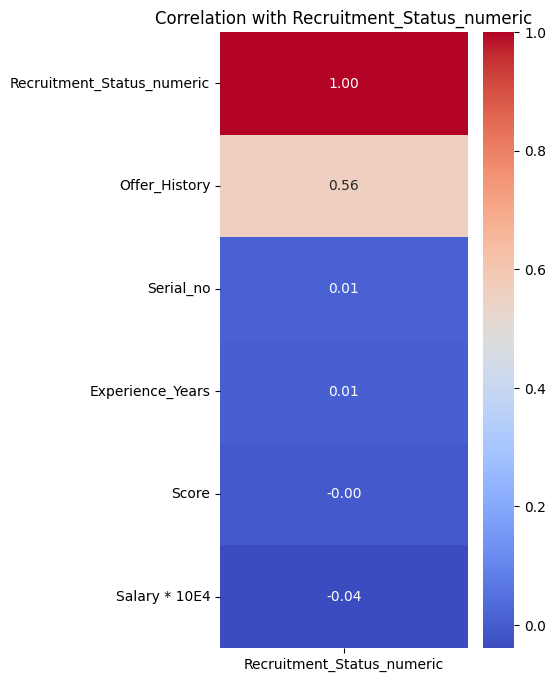

In [ ]:
#Ubah 'Recruitment_Status' menjadi format numerik untuk perhitungan korelasi.
df['Recruitment_Status_numeric'] = df['Recruitment_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Heatmap of the correlation (to the Target Column)
corr = df.corr(numeric_only=True)
target_column = 'Recruitment_Status_numeric'

column_corr = corr[[target_column]].sort_values(by=target_column, ascending=False)

plt.figure(figsize=(4, 8))
sns.heatmap(column_corr, annot=True, cmap='coolwarm', fmt='.2f')

plt.title(f'Correlation with {target_column}')
plt.show()

In [ ]:
#Membuat DataFrame(df) untuk keperluan visualisasi
viz_df = df.copy()

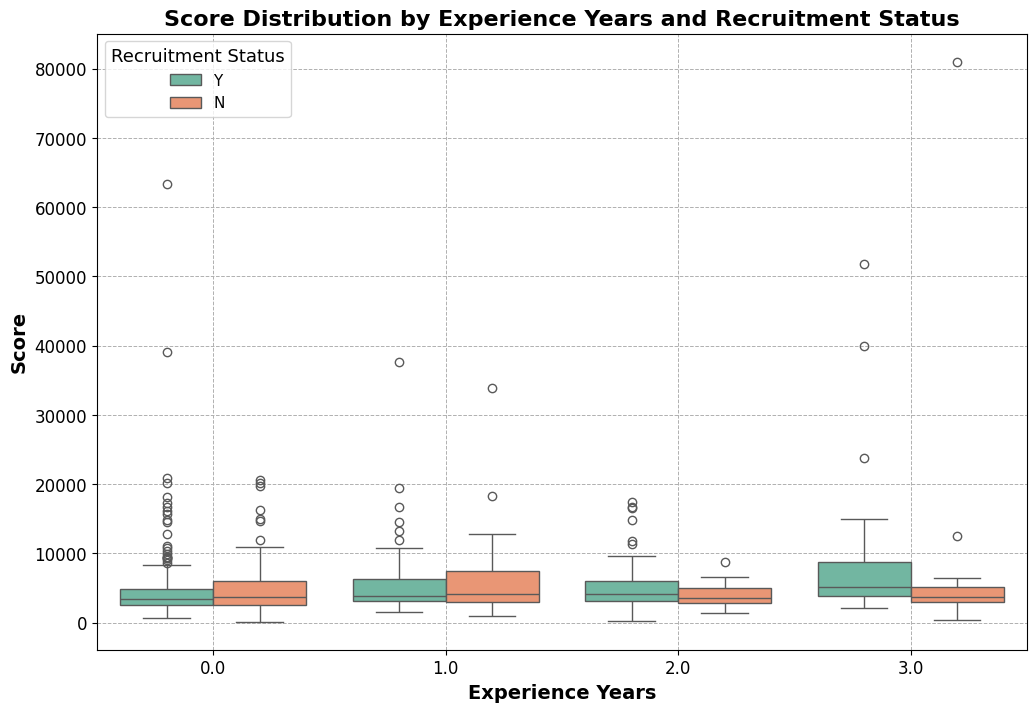

In [ ]:
#Diagram untuk mengamati variasi skor berdasarkan tahun pengalaman dan status rekrutmen.
plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(data=viz_df, x='Experience_Years', y='Score', hue='Recruitment_Status', palette='Set2')

boxplot.set_title('Score Distribution by Experience Years and Recruitment Status', fontsize=16, fontweight='bold')
boxplot.set_xlabel('Experience Years', fontsize=14, fontweight='bold')
boxplot.set_ylabel('Score', fontsize=14, fontweight='bold')
boxplot.legend(title='Recruitment Status', title_fontsize='13', fontsize='11')
boxplot.grid(True, linestyle='--', linewidth=0.7)

boxplot.tick_params(axis='x', labelsize=12)
boxplot.tick_params(axis='y', labelsize=12)
plt.show()

In [ ]:
bins = [0, 3, 8, float('inf')]
labels = ['Early Entry 0-3 YoE', 'Mid-Level 4-8 YoE', 'Senior 9+ YoE']
viz_df['ExperienceLevel'] = pd.cut(df['Experience_Years'], bins=bins, labels=labels, right=False)

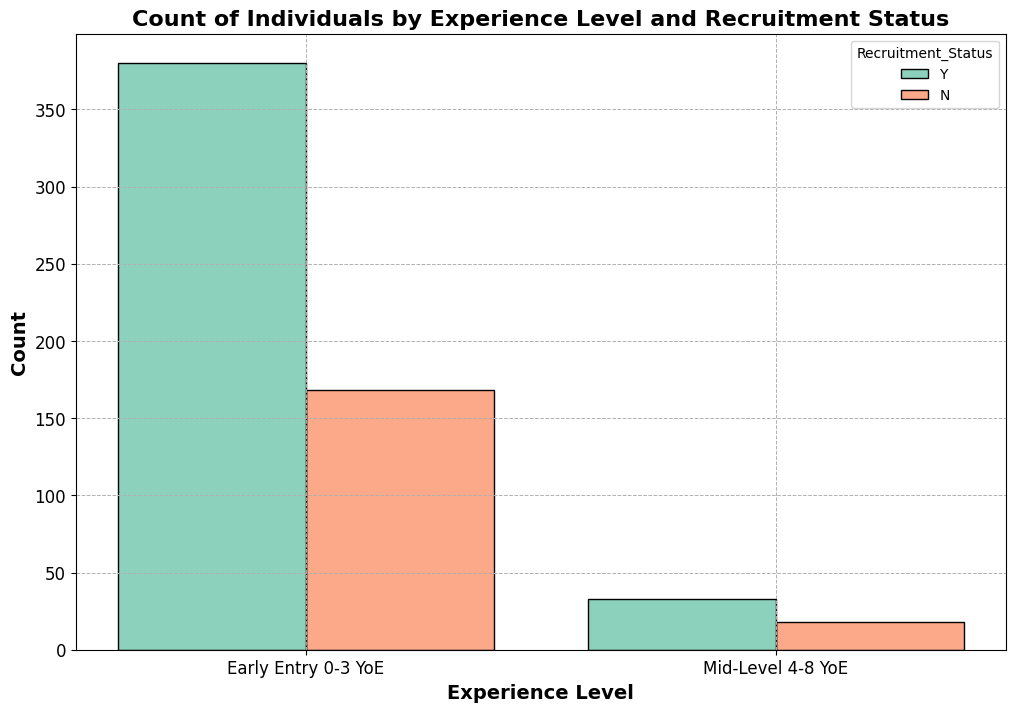

In [ ]:
## Diagram untuk mengamati kandidat dan profil mereka berdasarkan tahun pengalaman
plt.figure(figsize=(12, 8))
histogram = sns.histplot(data=viz_df, x='ExperienceLevel', hue='Recruitment_Status', multiple='dodge',shrink=0.8, palette='Set2', edgecolor='black')

histogram.set_title('Count of Individuals by Experience Level and Recruitment Status', fontsize=16, fontweight='bold')
histogram.set_xlabel('Experience Level', fontsize=14, fontweight='bold')
histogram.set_ylabel('Count', fontsize=14, fontweight='bold')

histogram.grid(True, linestyle='--', linewidth=0.7)

histogram.tick_params(axis='x', labelsize=12)
histogram.tick_params(axis='y', labelsize=12)
plt.show()

In [ ]:
##Logistic Regression
X = df.drop(['Recruitment_Status', 'Recruitment_Status_numeric', 'Serial_no'], axis=1) # Dropping target and identifier columns
y = df['Recruitment_Status_numeric'] # Using the numeric target varia

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
log_reg = LogisticRegression(solver='liblinear')

In [ ]:
from sklearn.impute import SimpleImputer

# Identifikasi fitur kategorikal dan numerik
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

#Buat sebuah column transformer untuk menerapkan langkah-langkah pra-pemrosesan yang berbeda pada kolom yang berbeda.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ],
    remainder='passthrough'
)

# Create a pipeline that first preprocesses the data and then applies the logistic regression model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear'))])

# Tentukan parameter grid untuk GridSearchCV, dengan menargetkan langkah classifier dalam pipeline.
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Experience_Years', 'Score', 'Salary * 10E4', 'Offer_History'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Python_exp', 'Education', 'Internship', 'Location'], dtype='object'))])),
                                       ('classifier',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}


In [ ]:
predictions = best_estimator.predict(x_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[18 19]
 [ 3 83]]
              precision    recall  f1-score   support

           0       0.86      0.49      0.62        37
           1       0.81      0.97      0.88        86

    accuracy                           0.82       123
   macro avg       0.84      0.73      0.75       123
weighted avg       0.83      0.82      0.80       123



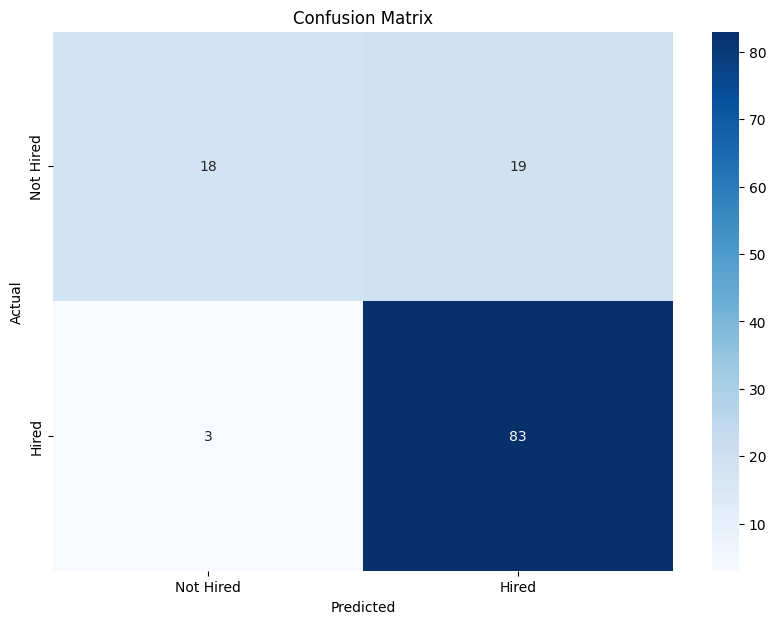

In [ ]:
# Matrix to compare results vs prediction
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hired', 'Hired'], yticklabels=['Not Hired', 'Hired'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Memprediksi menggunakan fitur-fitur saya dan melakukan uji A/B dengan input saya untuk dua tahun ke depan.
df = pd.read_csv('recruitment_decision_tree.csv')

print(df.columns)

# Ganti dengan kolom-kolom dari DataFrame yang sebenarnya digunakan dalam model.
columns = ['Gender', 'Python_exp', 'Experience_Years', 'Education', 'Internship', 'Score', 'Salary * 10E4', 'Offer_History', 'Location']

# Create a sample new data point using the actual columns
new_data = {
    'Gender': ['Male'],
    'Python_exp': ['Yes'],
    'Experience_Years': [2.0],  #Contoh nilai, sesuaikan sesuai kebutuhan
    'Education': ['Graduate'],
    'Internship': ['No'],
    'Score': [5000],  # Contoh nilai, sesuaikan sesuai kebutuhan
    'Salary * 10E4': [150.0],  # Contoh nilai, sesuaikan sesuai kebutuhan
    'Offer_History': [1.0],  # Contoh nilai, sesuaikan sesuai kebutuhan
    'Location': ['Urban']
}

new_df = pd.DataFrame(new_data)

Index(['Serial_no', 'Gender', 'Python_exp', 'Experience_Years', 'Education',
       'Internship', 'Score', 'Salary * 10E4', 'Offer_History', 'Location',
       'Recruitment_Status'],
      dtype='object')


In [ ]:
me_values = np.array([[24, 0, 1, 2, 1, 5000, 150, 1.0, 'Urban']]) # Menghapus nilai terakhir untuk mencocokkan kolom
future_me = np.array([[26, 0, 3, 4, 2, 6000, 180, 1.0, 'Urban']]) # Menghapus nilai terakhir untuk mencocokkan kolom
df_me = pd.DataFrame(data=me_values, columns=columns)
df_future = pd.DataFrame(data=future_me, columns=columns)
df_me

print("Kondisi Saya Saat Ini:")
print(df_me)

print("\nKondisi Saya 2 Tahun Lagi:")
print(df_future)

Kondisi Saya Saat Ini:
  Gender Python_exp Experience_Years Education Internship Score Salary * 10E4  \
0     24          0                1         2          1  5000           150   

  Offer_History Location  
0           1.0    Urban  

Kondisi Saya 2 Tahun Lagi:
  Gender Python_exp Experience_Years Education Internship Score Salary * 10E4  \
0     26          0                3         4          2  6000           180   

  Offer_History Location  
0           1.0    Urban  


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Assuming df is loaded from a previous cell
df = pd.read_csv('recruitment_decision_tree.csv')


# Convert 'Recruitment_Status' to numeric for correlation calculation - from cell Y1xpx3H6MVxS
df['Recruitment_Status_numeric'] = df['Recruitment_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Define features (X) and target (y) - from cell JTeZLOevYbsL
X = df.drop(['Recruitment_Status', 'Recruitment_Status_numeric', 'Serial_no'], axis=1) # Dropping target and identifier columns
y = df['Recruitment_Status_numeric'] # Using the numeric target varia

# Split data into training and testing sets - from cell JTeZLOevYbsL
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# Identify categorical and numerical features - from cell YiLnrUVVpsqP
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a column transformer to apply different preprocessing steps to different columns - from cell YiLnrUVVpsqP
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like Serial_no) if any, although we dropped it
)

# Create a pipeline that first preprocesses the data and then applies the logistic regression model - from cell YiLnrUVVpsqP
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear'))])

# Define the parameter grid for GridSearchCV, targeting the classifier step in the pipeline - from cell YiLnrUVVpsqP
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# Create and fit the GridSearchCV - from cell YiLnrUVVpsqP
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best estimator from the grid search - from cell mVIVJ1sMqQqN
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Define columns and create dataframes for prediction - from cells EndIolyD4cAd and j59WYJON7Uv-
columns = ['Gender', 'Python_exp', 'Experience_Years', 'Education', 'Internship', 'Score', 'Salary * 10E4', 'Offer_History', 'Location']
me_values = np.array([['Male', 'Yes', 2.0, 'Graduate', 'No', 5000, 150.0, 1.0, 'Urban']])
future_me = np.array([['Male', 'Yes', 4.0, 'Graduate', 'No', 6000, 180.0, 1.0, 'Urban']]) # Adjusted Experience_Years and Score for 2 years later

df_me = pd.DataFrame(data=me_values, columns=columns)
df_future = pd.DataFrame(data=future_me, columns=columns)

print("Kondisi Saya Saat Ini:")
print(df_me)

print("\nKondisi Saya 2 Tahun Lagi:")
print(df_future)


my_prediction = best_estimator.predict(df_me)
future_me_prediction = best_estimator.predict(df_future)

print(f"Current Hiring Prediction: {'You´re Hired' if my_prediction[0] == 1 else 'Maybe next time :p'}")
print(f"Future Hiring Prediction: {'You´re Hired' if future_me_prediction[0] == 1 else 'Maybe next time :p'}")

Kondisi Saya Saat Ini:
  Gender Python_exp Experience_Years Education Internship Score Salary * 10E4  \
0   Male        Yes              2.0  Graduate         No  5000         150.0   

  Offer_History Location  
0           1.0    Urban  

Kondisi Saya 2 Tahun Lagi:
  Gender Python_exp Experience_Years Education Internship Score Salary * 10E4  \
0   Male        Yes              4.0  Graduate         No  6000         180.0   

  Offer_History Location  
0           1.0    Urban  
Current Hiring Prediction: You´re Hired
Future Hiring Prediction: You´re Hired


In [ ]:
#Data (help with chatgpt since this chart is hard lol)
labels = ['Age', 'Education Level', 'Experience Years', 'Previous Companies',
          'Distance From Company', 'Interview Score', 'Skill Score', 'Personality Score', 'Recruitment Strategy']
me = [24.00, 1.00, 2.00, 1.00, 25.51, 50.56, 65.00, 65.00, 2.00]
mean_profile = [35.17, 2.49, 8.54, 3.09, 25.14, 56.80, 60.03, 56.79, 1.40]

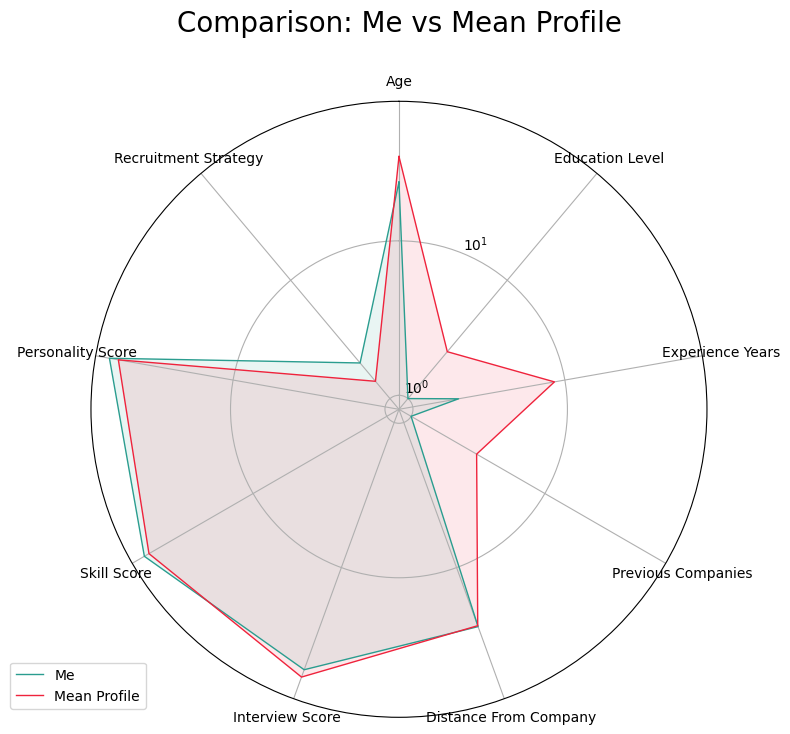

In [ ]:
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib

#Data (help with chatgpt since this chart is hard lol)
labels = ['Age', 'Education Level', 'Experience Years', 'Previous Companies',
          'Distance From Company', 'Interview Score', 'Skill Score', 'Personality Score', 'Recruitment Strategy']
me = [24.00, 1.00, 2.00, 1.00, 25.51, 50.56, 65.00, 65.00, 2.00]
mean_profile = [35.17, 2.49, 8.54, 3.09, 25.14, 56.80, 60.03, 56.79, 1.40]

num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop" and append the start value to the end.
me += me[:1]
mean_profile += mean_profile[:1]
angles += angles[:1]

# Size of the figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw y-labels
ax.set_rscale('log')
plt.xticks(angles[:-1], labels)

# Plot data with specified colors
ax.plot(angles, me, linewidth=1, linestyle='solid', label='Me', color='#2a9d8f')  # Color for 'Me'
ax.fill(angles, me, '#2a9d8f', alpha=0.1)

ax.plot(angles, mean_profile, linewidth=1, linestyle='solid', label='Mean Profile', color='#ef233c')  # Color for 'Mean Profile'
ax.fill(angles, mean_profile, '#ef233c', alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Title
plt.title('Comparison: Me vs Mean Profile', size=20, y=1.1)

plt.show()